In [119]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
files = !(ls *.csv)
clients = ['1', '2', '5', '10', '20', '50', '100', '150']

In [136]:
df = pd.DataFrame()
for file in files:
    m = {"client" : [], "latency" : []}
    if 'fault-tol' in file:
        continue
    with open(file, 'r') as f:
        # get No of columns in each line
        doc = f.readlines()
        for line in doc:
            line_list = line.split(',')
            client = line_list[0]
            for lat in line_list[1:]:
                m['client'].append(int(client[6:]))
                m['latency'].append(int(lat) / 1000)
    d = pd.DataFrame.from_dict(m)
    name = file.split(".")[0]
    name = '-'.join(name.split("-")[1:-1])
    d['name'] = name
    df = pd.concat([df, d])

In [122]:
def get_tail(df, name, tail):
    return df[df.name == name].groupby(['client', 'name']).quantile(tail).values.flatten()

In [123]:
def get_mean(df, name):
    return df[df.name == name].groupby('client').mean().values.flatten()

# Performance Metrics

## GET and SET

<IPython.core.display.Javascript object>


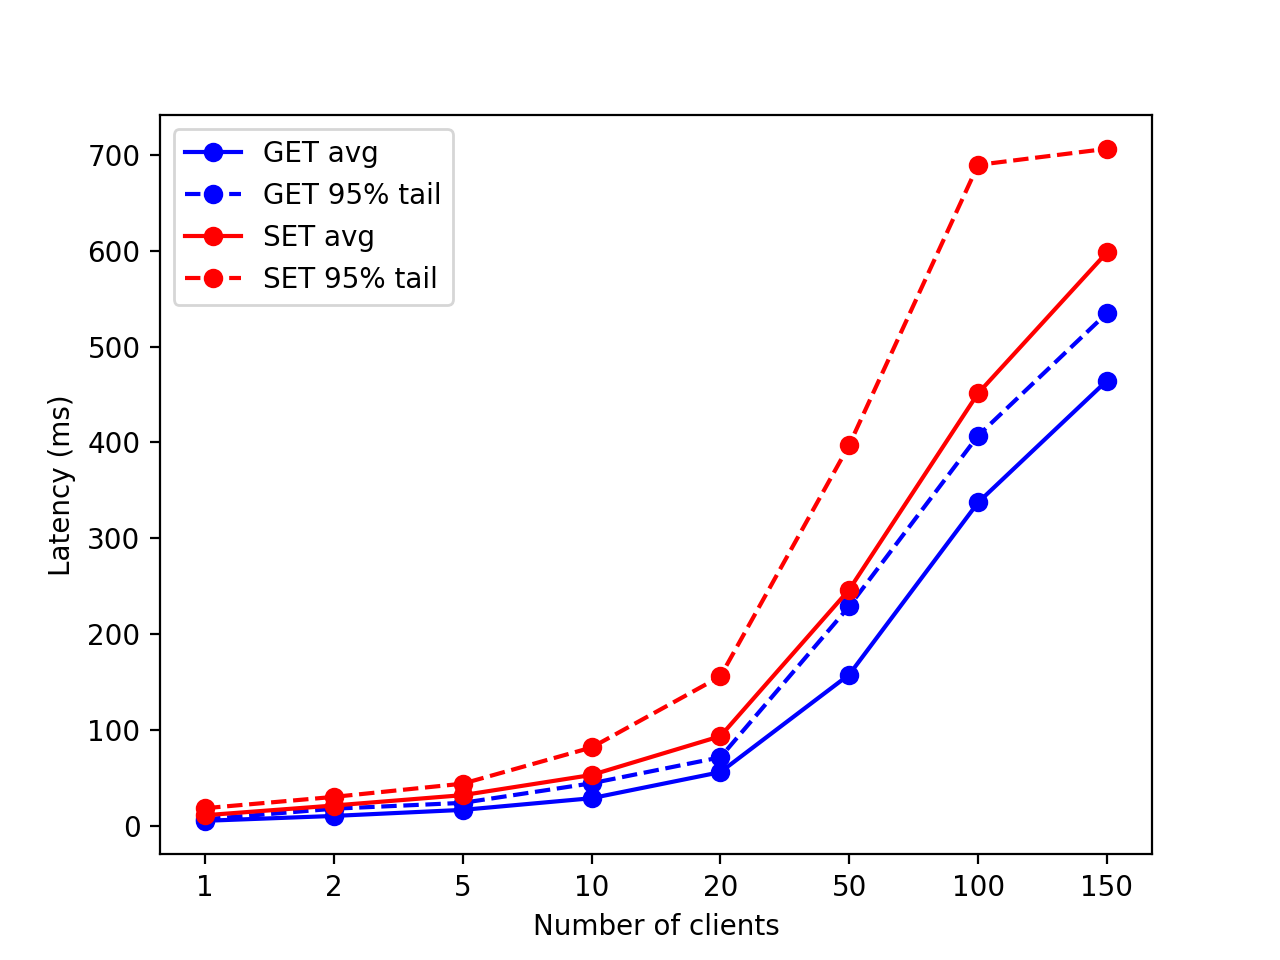

In [137]:
plt.plot(clients, get_mean(df, 'get'), 'o-b', label='GET avg')
plt.plot(clients, get_tail(df, 'get', 0.95), 'o--b', label='GET 95% tail')
plt.plot(clients, get_mean(df, 'set-0'), 'o-r', label='SET avg')
plt.plot(clients, get_tail(df, 'set-0', 0.95), 'o--r', label='SET 95% tail')
plt.xticks(list(range(len(clients))), clients)
plt.xlabel("Number of clients")
plt.ylabel("Latency (ms)")
plt.legend(loc="upper left")
plt.show()

## SET w. and w.o. conflict

<IPython.core.display.Javascript object>


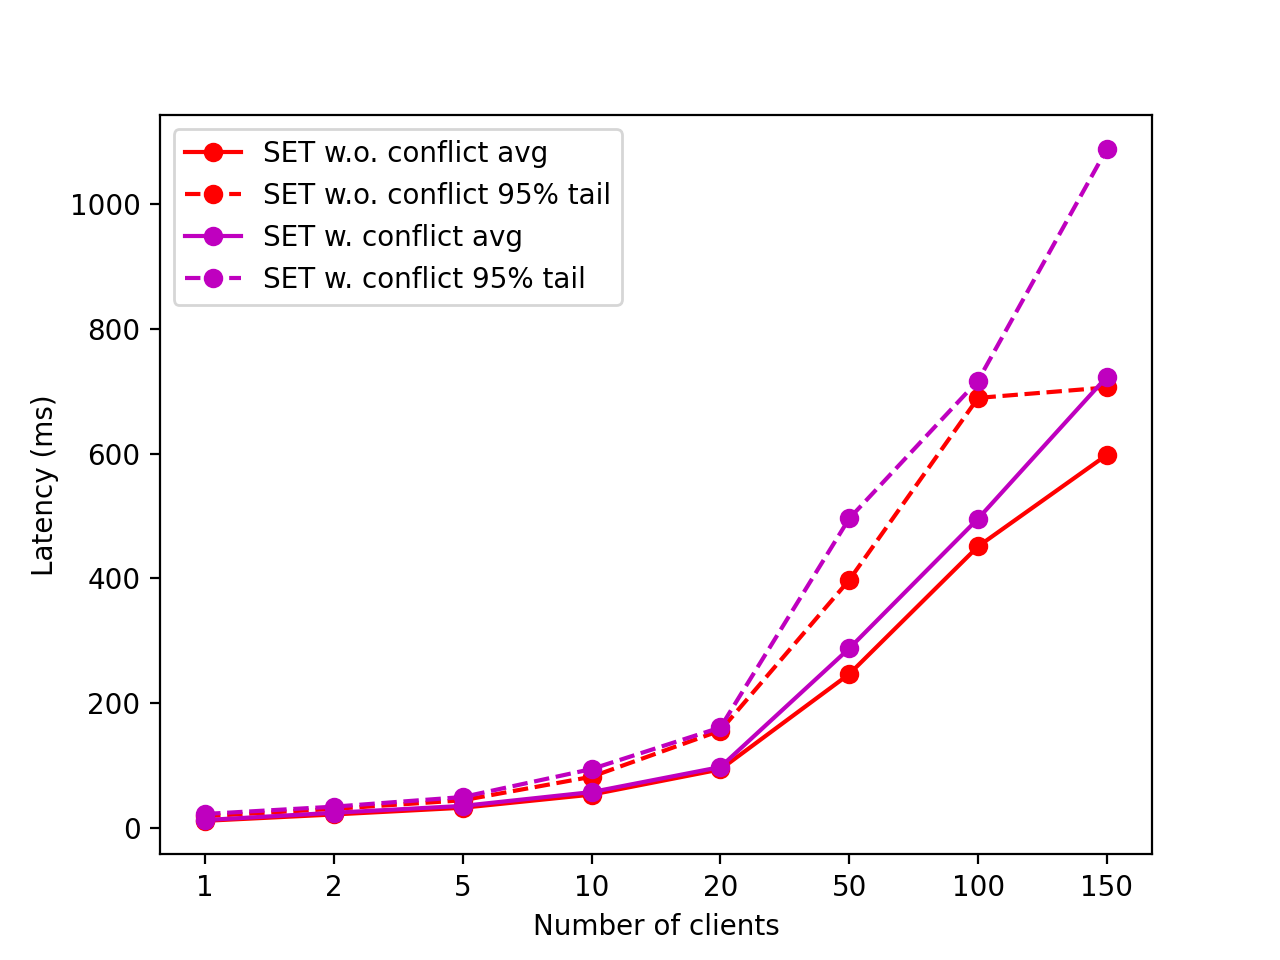

In [138]:
plt.plot(clients, get_mean(df,'set-0', ), 'o-r', label='SET w.o. conflict avg')
plt.plot(clients, get_tail(df,'set-0', 0.95), 'o--r', label='SET w.o. conflict 95% tail')
plt.plot(clients, get_mean(df,'set-5', ), 'o-m', label='SET w. conflict avg')
plt.plot(clients, get_tail(df,'set-5', 0.95), 'o--m', label='SET w. conflict 95% tail')
plt.xlabel("Number of clients")
plt.ylabel("Latency (ms)")
plt.xticks(list(range(len(clients))), clients)
plt.legend(loc="upper left")
plt.show()

## TXN and READ-ONLY TXN

<IPython.core.display.Javascript object>


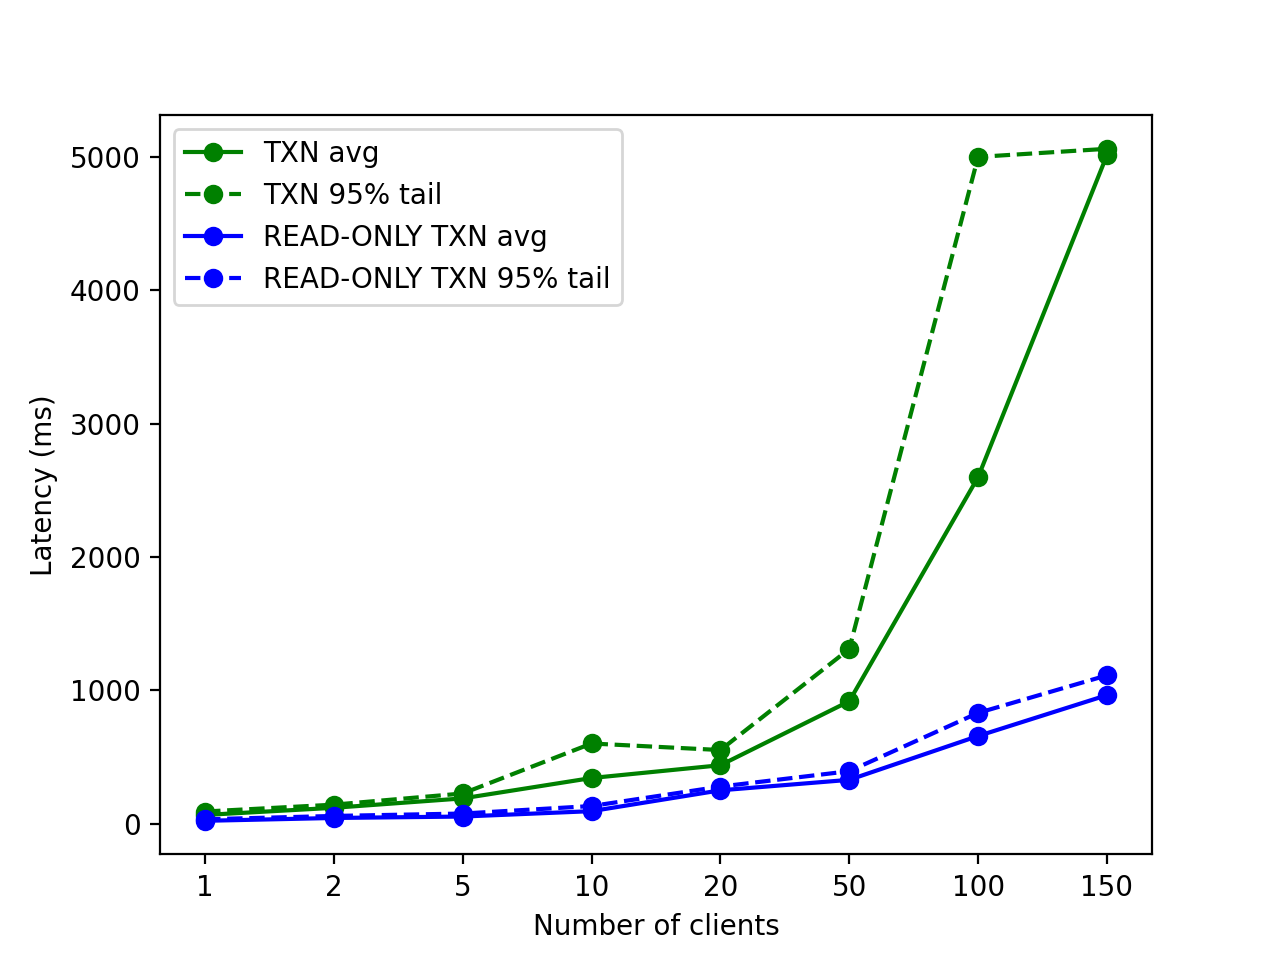

In [139]:
plt.plot(clients, get_mean(df, 'txn-0-single'), 'o-', color = 'g', label='TXN avg')
plt.plot(clients, get_tail(df, 'txn-0-single', 0.95), 'o--', color = 'g', label='TXN 95% tail')
plt.plot(clients, get_mean(df, 'read-0-multiple'), 'o-', color = 'b', label='READ-ONLY TXN avg')
plt.plot(clients, get_tail(df, 'read-0-multiple', 0.95), 'o--', color = 'b', label='READ-ONLY TXN 95% tail')
plt.xlabel("Number of clients")
plt.ylabel("Latency (ms)")
plt.legend(loc="upper left")
plt.show()

## ADD and XFER

<IPython.core.display.Javascript object>


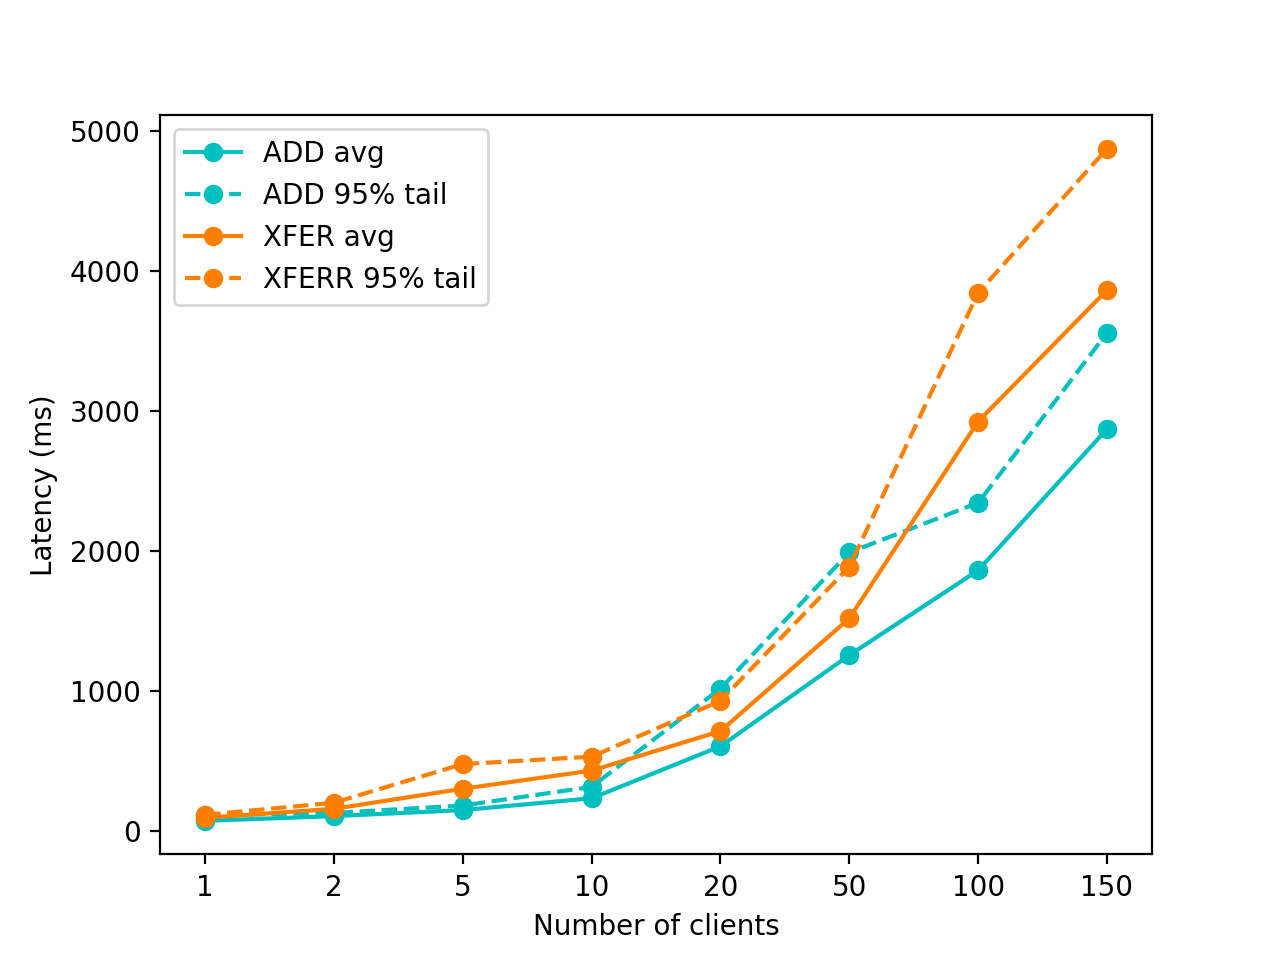

In [140]:
plt.plot(clients, get_mean(df, 'add-0'), 'o-', color = 'c', label='ADD avg')
plt.plot(clients, get_tail(df, 'add-0', 0.95), 'o--', color = 'c', label='ADD 95% tail')
plt.plot(clients, get_mean(df, 'xfer'), 'o-', color = '#ff7f00', label='XFER avg')
plt.plot(clients, get_tail(df, 'xfer', 0.95), 'o--', color = '#ff7f00', label='XFERR 95% tail')
plt.xlabel("Number of clients")
plt.ylabel("Latency (ms)")
plt.legend(loc="upper left")
plt.show()

## Fault Tolerance Test

In [133]:
nano_mill = 10**6
file = [f for f in files if 'fault-tol' in f][0]
df = pd.read_csv(file)
df.sort_values("end", inplace=True)
df = df[pd.isna(df.error)]
set_time = df[df.op == "set"].end.values / nano_mill
get_time = df[(df.op == "get")].end.values / nano_mill

<IPython.core.display.Javascript object>


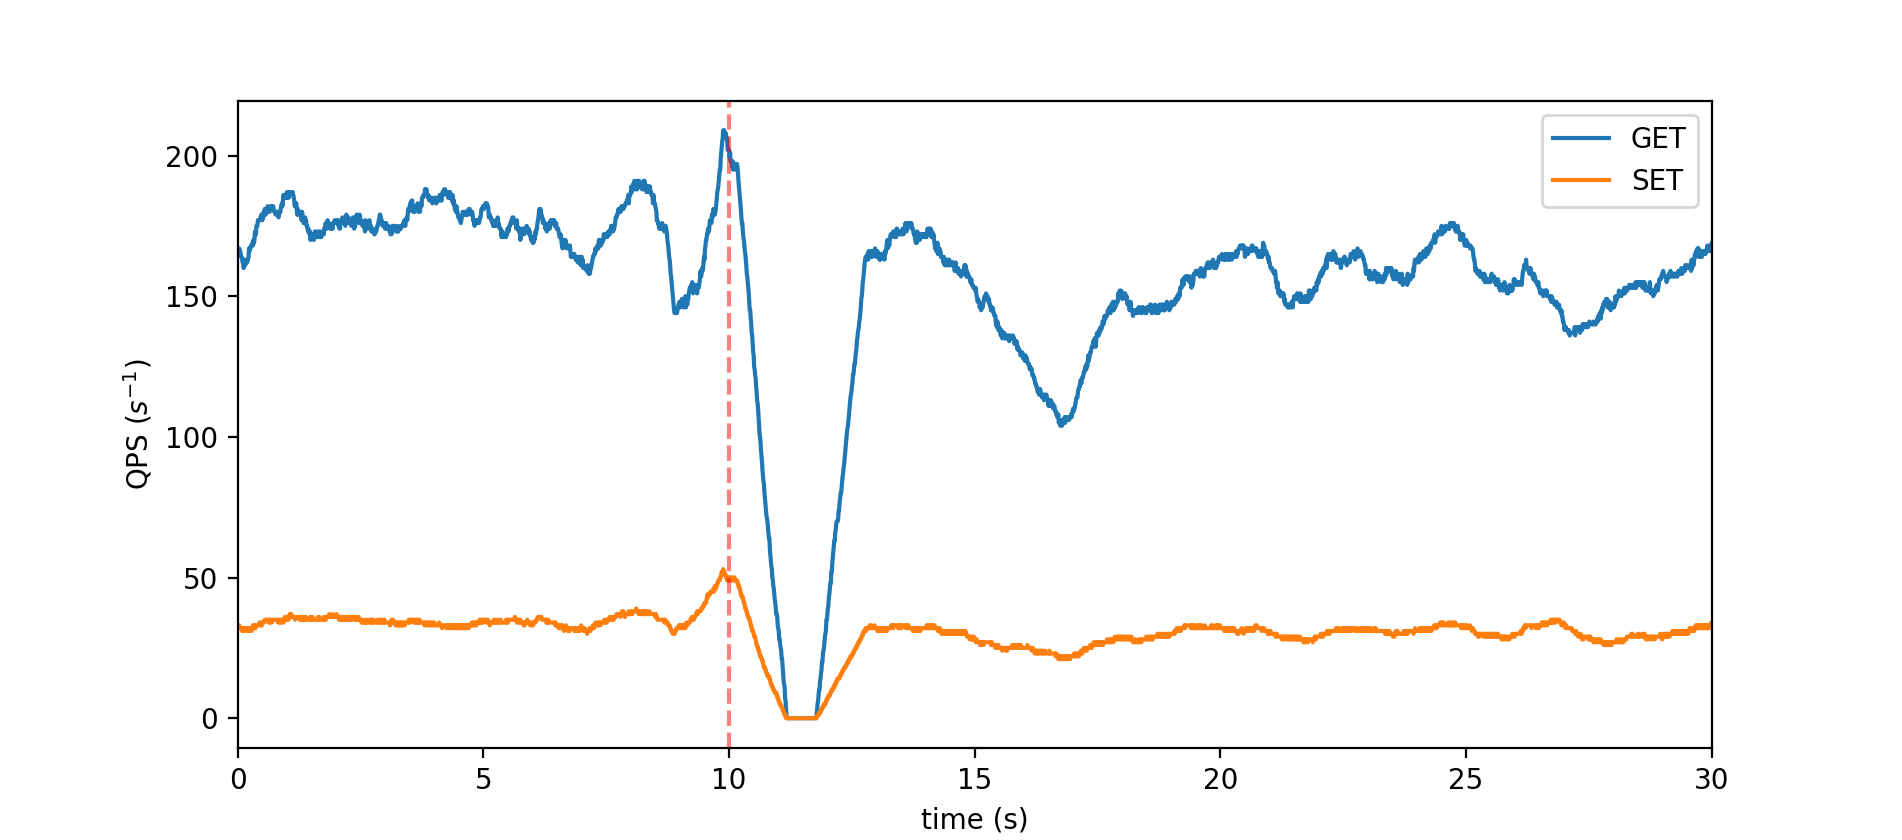

In [142]:
time, get_qps, set_qps = np.array([]), np.array([]), np.array([])

res = 1000 # 10 ms
start = 0
end = start + res
while start <= get_time[-1]:
    set_n = np.sum((set_time >= start) & (set_time < end)) * (1000/res)
    get_n = np.sum((get_time >= start) & (get_time < end)) * (1000/res)
    time = np.append(time, (start + end) / 2 / 1000)
    get_qps = np.append(get_qps, get_n)
    set_qps = np.append(set_qps, set_n)
    start += 10
    end = start + res
    
plt.plot(time-3.5, get_qps, label = "GET")
plt.plot(time-3.5, set_qps, label = 'SET')
plt.xlim(0, 30)
plt.xlabel("time (s)")
plt.ylabel(r"QPS ($s^{-1}$)")
plt.axvline(x = 10, color='r', alpha = 0.5, linestyle = '--')
plt.legend()
plt.show()